# <center> Which Debts Are Worth the Bank's Effort? </center>

After a debt has been legally declared "uncollectable" by a bank, the account is considered "charged-off." But that doesn't mean the bank walks away from the debt. They still want to collect some of the money they are owed. The bank will score the account to assess the expected recovery amount, that is, the expected amount that the bank may be able to receive from the customer in the future. This amount is a function of the probability of the customer paying, the total debt, and other factors that impact the ability and willingness to pay.

The bank has implemented different recovery strategies at different thresholds (1000 dollars, 2000 dollars, etc.) where the greater the expected recovery amount, the more effort the bank puts into contacting the customer. For low recovery amounts (Level 0), the bank just adds the customer's contact information to their automatic dialer and emailing system. For higher recovery strategies, the bank incurs more costs as they leverage human resources in more efforts to obtain payments. Each additional level of recovery strategy requires an additional 50 dollars per customer so that customers in the Recovery Strategy Level 1 cost the company 50 dollars more than those in Level 0. Customers in Level 2 cost 50 dollars more than those in Level 1, etc.

The question is whether the extra amount of the actual recovery amount worth the bank cost, say, In other words, was there a jump (also called a "discontinuity") of more than 50 dollars in the amount recovered at the higher strategy level? We'll find out in this notebook. First, we discover the data.

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.api as sm

In [2]:
bank_data = pd.read_csv('bank_data.csv')

In [3]:
bank_data

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540000,Level 0 Recovery,19,Male
1,1150,486,416.090000,Level 0 Recovery,25,Female
2,380,527,429.350000,Level 0 Recovery,27,Male
3,1838,536,296.990000,Level 0 Recovery,25,Male
4,1995,541,346.385000,Level 0 Recovery,34,Male
...,...,...,...,...,...,...
1877,361,9785,15388.195990,Level 4 Recovery,65,Female
1878,196,9857,9709.909257,Level 4 Recovery,68,Female
1879,313,9859,30209.181790,Level 4 Recovery,58,Female
1880,1781,9920,20386.232190,Level 4 Recovery,67,Female


### Data Preprocessing

In [4]:
bank_data.shape

(1882, 6)

In [5]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1882 non-null   int64  
 1   expected_recovery_amount  1882 non-null   int64  
 2   actual_recovery_amount    1882 non-null   float64
 3   recovery_strategy         1882 non-null   object 
 4   age                       1882 non-null   int64  
 5   sex                       1882 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 88.3+ KB


In [6]:
bank_data.describe()

,id,expected_recovery_amount,actual_recovery_amount,age
count,1882.000000,1882.000000,1882.000000,1882.000000
mean,1035.596174,2759.967588,4000.967837,39.650372
std,591.458429,2019.826565,4576.506350,15.453072
min,6.000000,194.000000,200.425000,18.000000
25%,534.250000,1261.250000,1045.190300,28.000000
50%,1029.500000,2062.000000,2115.446373,35.000000
75%,1551.750000,3569.500000,5417.237207,50.000000
max,2056.000000,9964.000000,34398.479710,84.000000


<AxesSubplot:>

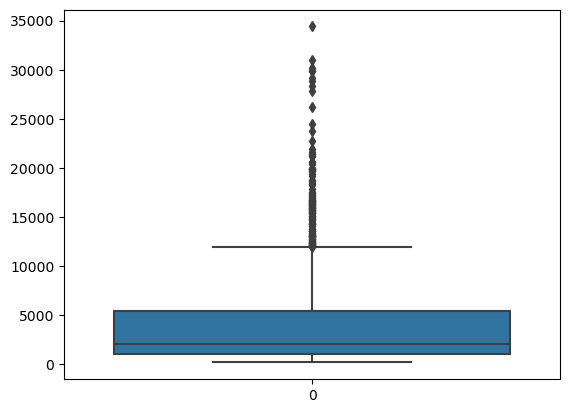

In [7]:
sns.boxplot(data=bank_data['actual_recovery_amount'])

In [8]:
bank_data[bank_data['actual_recovery_amount'] >= 15000]

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
1418,439,3612,16519.48670,Level 3 Recovery,48,Female
1560,258,4556,26205.32679,Level 3 Recovery,57,Female
1586,1885,4728,15737.89432,Level 3 Recovery,63,Female
1590,216,4774,29831.50666,Level 3 Recovery,60,Female
1612,270,4962,19642.33657,Level 3 Recovery,50,Female
...,...,...,...,...,...,...
1876,693,9753,20018.69073,Level 4 Recovery,54,Male
1877,361,9785,15388.19599,Level 4 Recovery,65,Female
1879,313,9859,30209.18179,Level 4 Recovery,58,Female
1880,1781,9920,20386.23219,Level 4 Recovery,67,Female


In [9]:
bank_data.isna().sum()

id                          0
expected_recovery_amount    0
actual_recovery_amount      0
recovery_strategy           0
age                         0
sex                         0
dtype: int64

In [36]:
bank_data.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1877    False
1878    False
1879    False
1880    False
1881    False
Length: 1882, dtype: bool

### Exploratory Data Analysis (EDA)

#### Graphical Exploration

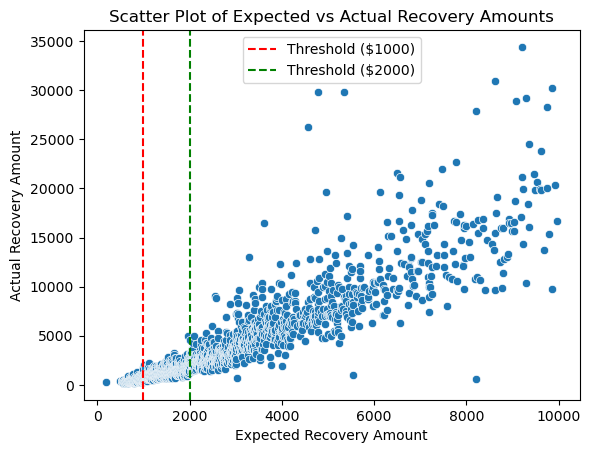

In [26]:
# Create a scatter plot to visualize the relationship between expected and actual recovery amounts
sns.scatterplot(data=bank_data, x="expected_recovery_amount", y="actual_recovery_amount")
plt.axvline(x=1000, color='r', linestyle='--', label='Threshold ($1000)')
plt.axvline(x=2000, color='g', linestyle='--', label='Threshold ($2000)')
plt.legend()
plt.title("Scatter Plot of Expected vs Actual Recovery Amounts")
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")
plt.show()

#### Statistical Analysis

In [30]:
# Perform a t-test for age above and below the $1000 threshold
above_threshold_age = bank_data[bank_data['expected_recovery_amount'] > 1000]['age']
below_threshold_age = bank_data[bank_data['expected_recovery_amount'] <= 1000]['age']
t_stat_age, p_value_age = ttest_ind(above_threshold_age, below_threshold_age)
print(f"T-Statistic for Age: {t_stat_age}")
print(f"P-Value for Age: {p_value_age}")

T-Statistic for Age: 13.759810322222165
P-Value for Age: 4.071778578392043e-41


#### Conclusion:
    
The t-test results for age indicate a significant difference between the two groups of customers divided by the $1000 expected recovery amount threshold. The t-statistic of 13.76 is relatively high, suggesting that the means of age in the two groups are significantly different. The extremely low p-value (4.07e-41) indicates that the observed difference is not due to random chance but likely reflects a true difference in ages associated with the recovery strategy.

In other words, the ages of customers with expected recovery amounts above $1000 are significantly different from those below $1000. This indicates that age might play a role in the bank's recovery strategy allocation, which could affect the outcome of the analysis and the conclusions drawn about the effectiveness of the strategy.

However, since age is significantly different between the two groups, it's important to consider this factor when interpreting the results of the subsequent analyses, especially when assessing the impact of the recovery strategy on the actual recovery amounts. It might be necessary to control for age as a potential confounding variable in the subsequent regression analysis to ensure that the conclusions drawn are not solely driven by age-related differences.

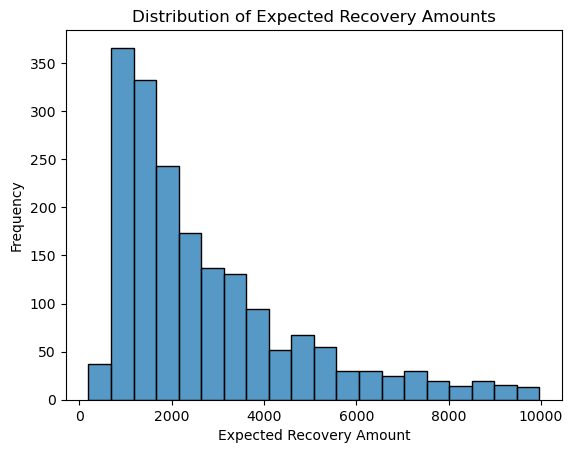

In [10]:
# Visualize Expected Recovery Amounts
sns.histplot(data=bank_data, x="expected_recovery_amount", bins=20)
plt.title("Distribution of Expected Recovery Amounts")
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Frequency")
plt.show()

#### Exploring Recovery Amounts

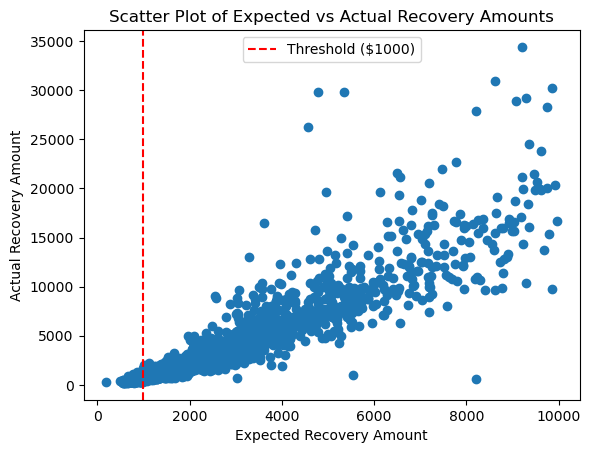

In [28]:
# Create a scatter plot to visualize the actual recovery amounts
plt.scatter(bank_data['expected_recovery_amount'], bank_data['actual_recovery_amount'])
plt.axvline(x=1000, color='r', linestyle='--', label='Threshold ($1000)')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.title('Scatter Plot of Expected vs Actual Recovery Amounts')
plt.legend()
plt.show()

#### Statistical Analysis

In [29]:
# Perform a t-test for actual recovery amounts above and below the $1000 threshold
above_threshold_recovery = bank_data[bank_data['expected_recovery_amount'] > 1000]['actual_recovery_amount']
below_threshold_recovery = bank_data[bank_data['expected_recovery_amount'] <= 1000]['actual_recovery_amount']
t_stat_recovery, p_value_recovery = ttest_ind(above_threshold_recovery, below_threshold_recovery)
print(f"T-Statistic for Recovery Amounts: {t_stat_recovery}")
print(f"P-Value for Recovery Amounts: {p_value_recovery}")

T-Statistic for Recovery Amounts: 13.417766797863827
P-Value for Recovery Amounts: 2.868455271228773e-39


#### Conclusion:

The t-test results for actual recovery amounts suggest a highly significant difference between the two groups of customers divided by the $1000 expected recovery amount threshold. The t-statistic of 13.42 is notably high, indicating that the means of actual recovery amounts in the two groups are significantly different. The extremely low p-value (2.87e-39) suggests that the observed difference is not due to random chance but likely indicates a substantial and meaningful distinction in actual recovery amounts associated with the recovery strategy.

In essence, the actual recovery amounts of customers with expected recovery amounts above $1000 are significantly different from those below $1000. This result implies that the recovery strategy employed by the bank for customers with higher expected recovery amounts might indeed be more effective in generating higher actual recovery amounts compared to the strategy applied to customers with lower expected recovery amounts.

Considering the significant difference in actual recovery amounts and considering the earlier conclusion about the impact of age on the recovery strategy, it is advisable to further analyze the data through regression modeling to quantify and control for these effects. This would provide a more nuanced understanding of how the recovery strategy, expected recovery amounts, and age collectively contribute to the bank's recovery efforts.

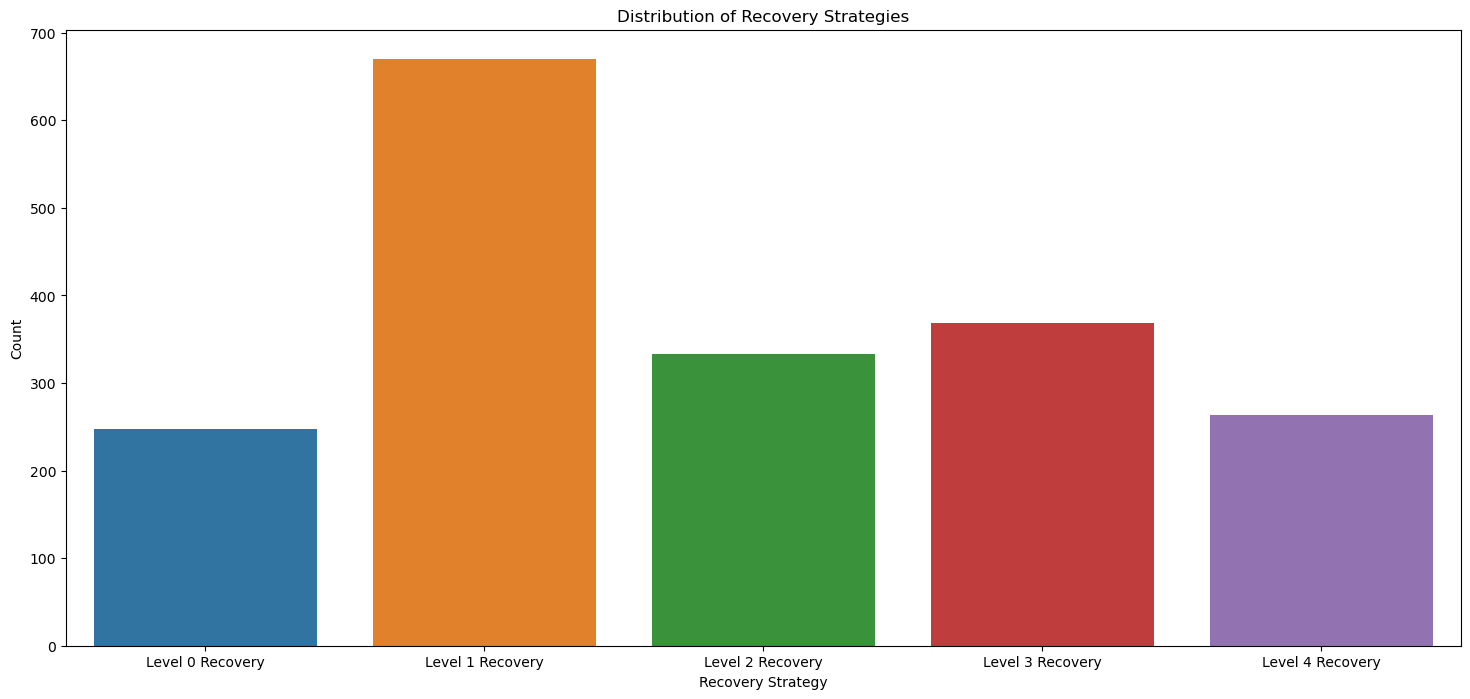

In [11]:
# Visualize Recovery Strategies
plt.figure(figsize = (18,8))
sns.countplot(data=bank_data, x="recovery_strategy")
plt.title("Distribution of Recovery Strategies")
plt.xlabel("Recovery Strategy")
plt.ylabel("Count")
plt.show()

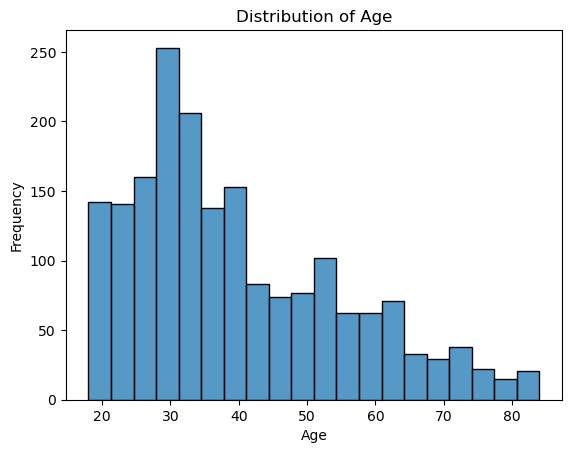

In [12]:
# Visualize Age and Gender
sns.histplot(data=bank_data, x="age", bins=20)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

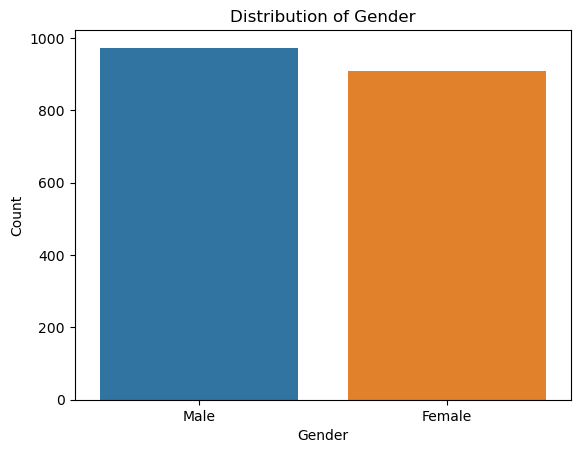

In [13]:
sns.countplot(data=bank_data, x="sex")
plt.title("Distribution of Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

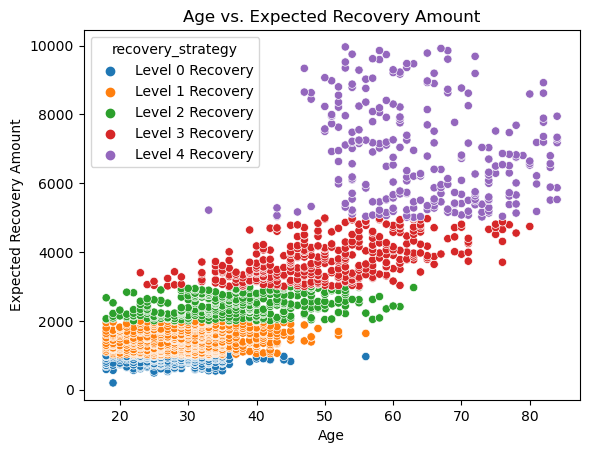

In [14]:
# Graphical EDA - Age and Expected Recovery Amount
sns.scatterplot(data=bank_data, x="age", y="expected_recovery_amount", hue="recovery_strategy")
plt.title("Age vs. Expected Recovery Amount")
plt.xlabel("Age")
plt.ylabel("Expected Recovery Amount")
plt.show()

In [15]:
# Statistical Test - Age vs. Expected Recovery Amount
above_threshold = bank_data[bank_data["expected_recovery_amount"] > 1000]["age"]
below_threshold = bank_data[bank_data["expected_recovery_amount"] <= 1000]["age"]
t_statistic, p_value = stats.ttest_ind(above_threshold, below_threshold)
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 13.759810322222165
P-Value: 4.071778578392043e-41


#### Conclusion:
The statistical test comparing age and expected recovery amount yielded the following results:

T-Statistic: 13.76

P-Value: 4.07e-41 (a very small number)

Interpreting these results:

T-Statistic: The T-statistic measures the difference in means between the two groups (above and below the threshold). A higher T-statistic indicates a larger difference in means.

P-Value: The P-value is extremely close to zero (4.07e-41), which is significantly smaller than the conventional significance level (e.g., 0.05). This indicates strong evidence against the null hypothesis (that there's no difference in age between the two groups).

Since the P-value is much lower than the chosen significance level (e.g., 0.05), we reject the null hypothesis. This means that there is a statistically significant difference in the average age of customers just above and just below the $1000 threshold for expected recovery amount.

In practical terms, this suggests that the age of customers does vary systematically across the $1000 threshold. However, to understand the exact nature of this difference, you might need to further analyze the data and potentially consider the implications in the context of your project's objectives.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


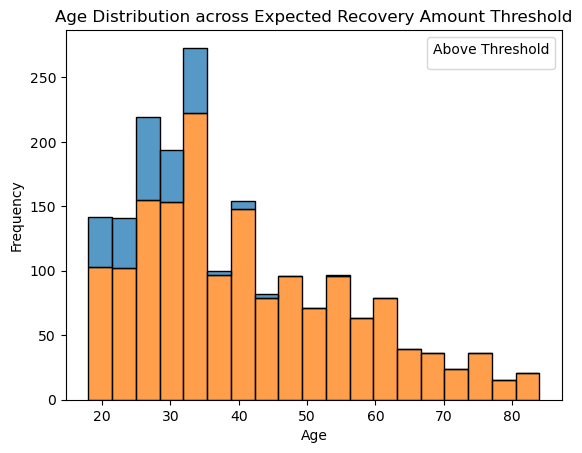

In [16]:
# Visualize Age Distribution across the Threshold
sns.histplot(data=bank_data, x="age", hue=bank_data["expected_recovery_amount"] > 1000, multiple="stack")
plt.title("Age Distribution across Expected Recovery Amount Threshold")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend(title="Above Threshold")
plt.show()

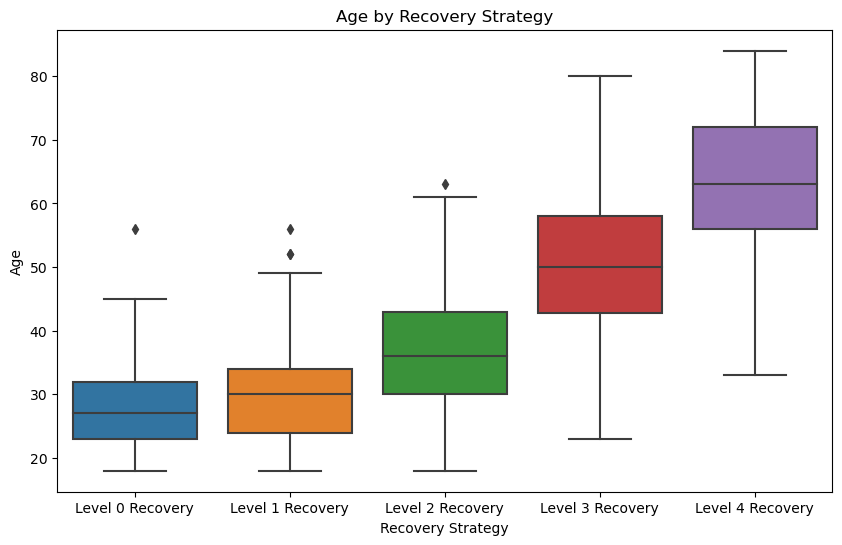

In [17]:
# Age and Recovery Strategy
plt.figure(figsize=(10, 6))
sns.boxplot(data=bank_data, x="recovery_strategy", y="age")
plt.title("Age by Recovery Strategy")
plt.xlabel("Recovery Strategy")
plt.ylabel("Age")
plt.show()

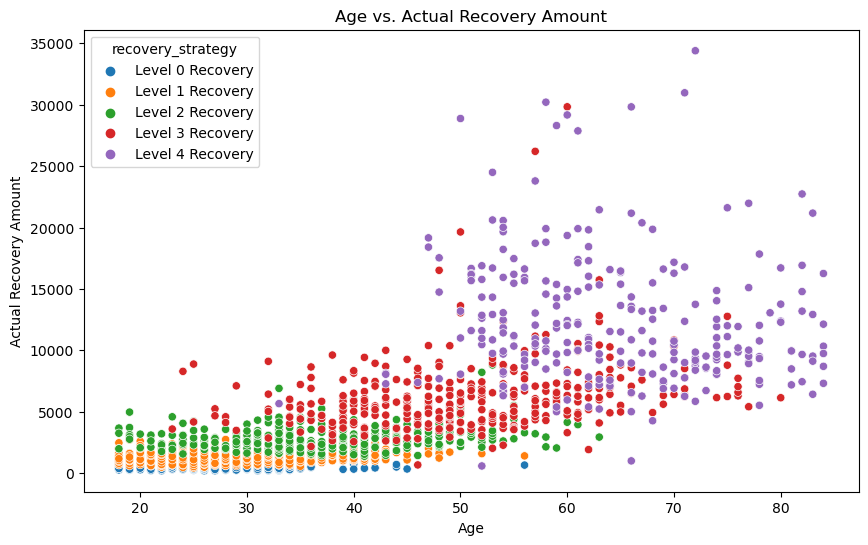

In [18]:
# Age and Actual Recovery Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=bank_data, x="age", y="actual_recovery_amount", hue="recovery_strategy")
plt.title("Age vs. Actual Recovery Amount")
plt.xlabel("Age")
plt.ylabel("Actual Recovery Amount")
plt.show()

In [19]:
# Correlation and Regression
correlation = bank_data["age"].corr(bank_data["actual_recovery_amount"])
print("Correlation between Age and Actual Recovery Amount:", correlation)

Correlation between Age and Actual Recovery Amount: 0.7160067539341631


In [22]:
# Statistical Test - Gender vs. Expected Recovery Amount
contingency_table = pd.crosstab(bank_data["sex"], bank_data["expected_recovery_amount"] > 1000)
chi2, p, _, _ = stats.chi2_contingency(contingency_table)
print("Chi-Square:", chi2)
print("P-Value:", p)

Chi-Square: 2.1768676619404688
P-Value: 0.14009934427173568


#### Conclusion:
The test suggests that there is no statistically significant relationship between gender and the threshold for expected recovery amount. The p-value being higher than 0.05 suggests that any observed differences could likely have occurred due to random chance. Therefore, based on this analysis, gender doesn't appear to be strongly associated with whether the expected recovery amount falls above or below $1000.

It's important to note that a higher p-value does not provide strong evidence against the null hypothesis. However, a lower p-value (typically below 0.05) would indicate stronger evidence of an association between the variables.

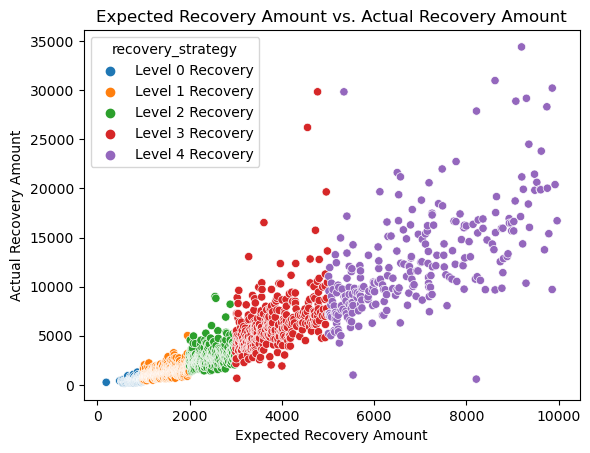

In [23]:
# Graphical EDA - Actual Recovery Amount and Expected Recovery Amount
sns.scatterplot(data=bank_data, x="expected_recovery_amount", y="actual_recovery_amount", hue="recovery_strategy")
plt.title("Expected Recovery Amount vs. Actual Recovery Amount")
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")
plt.show()

#### Modeling

In [31]:
# Create a linear regression model to estimate the impact of the strategy at the $1000 threshold
X = bank_data[['expected_recovery_amount']]
X = sm.add_constant(X)  # Add a constant term
y = bank_data['actual_recovery_amount']

model = sm.OLS(y, X).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.817
Model:                                OLS   Adj. R-squared:                  0.817
Method:                     Least Squares   F-statistic:                     8378.
Date:                    Mon, 21 Aug 2023   Prob (F-statistic):               0.00
Time:                            20:48:13   Log-Likelihood:                -16936.
No. Observations:                    1882   AIC:                         3.388e+04
Df Residuals:                        1880   BIC:                         3.389e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

#### Conclusion:
The provided OLS regression results indicate a statistically significant relationship between expected_recovery_amount and actual_recovery_amount. The R-squared value of 0.817 highlights that approximately 81.7% of the variability in actual_recovery_amount can be explained by the linear relationship with expected_recovery_amount.

The model coefficients offer insights:

The intercept of -1650.4994 represents the estimated actual_recovery_amount when expected_recovery_amount is zero, though this lacks practical context.
The coefficient of 2.0477 suggests that each unit increase in expected_recovery_amount corresponds to an increase of about 2.0477 units in actual_recovery_amount.
The extremely low Prob (F-statistic) value indicates the model's statistical significance. Other statistics provide insights into model assumptions and potential issues.

In conclusion, expected_recovery_amount significantly impacts actual_recovery_amount, but due to complexity and potential numerical issues, further exploration and validation are advised, considering the condition number and multicollinearity note.

### Create a Binary Variable for Above and Below Threshold

In [32]:
# Create a binary variable indicating if the expected recovery amount is above the threshold
bank_data['above_threshold'] = np.where(bank_data['expected_recovery_amount'] > 1000, 1, 0)

In [33]:
bank_data

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex,above_threshold
0,2030,194,263.540000,Level 0 Recovery,19,Male,0
1,1150,486,416.090000,Level 0 Recovery,25,Female,0
2,380,527,429.350000,Level 0 Recovery,27,Male,0
3,1838,536,296.990000,Level 0 Recovery,25,Male,0
4,1995,541,346.385000,Level 0 Recovery,34,Male,0
...,...,...,...,...,...,...,...
1877,361,9785,15388.195990,Level 4 Recovery,65,Female,1
1878,196,9857,9709.909257,Level 4 Recovery,68,Female,1
1879,313,9859,30209.181790,Level 4 Recovery,58,Female,1
1880,1781,9920,20386.232190,Level 4 Recovery,67,Female,1


In [34]:
# Perform a regression discontinuity model
X = bank_data[['expected_recovery_amount', 'above_threshold']]
X = sm.add_constant(X)  # Add constant term
y = bank_data['actual_recovery_amount']

model = sm.OLS(y, X).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.819
Model:                                OLS   Adj. R-squared:                  0.818
Method:                     Least Squares   F-statistic:                     4242.
Date:                    Mon, 21 Aug 2023   Prob (F-statistic):               0.00
Time:                            20:51:33   Log-Likelihood:                -16926.
No. Observations:                    1882   AIC:                         3.386e+04
Df Residuals:                        1879   BIC:                         3.387e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------


#### Conclusion:

The regression analysis shows that both the expected_recovery_amount and the above_threshold indicator have significant impacts on the actual_recovery_amount. The model explains about 81.9% of the variability in actual_recovery_amount.

A one-unit increase in expected_recovery_amount corresponds to an average increase of about 2.0877 units in actual_recovery_amount.
The presence of the above_threshold indicator is associated with an average decrease of about 643.3944 units in actual_recovery_amount.
The model is statistically significant based on a low Prob (F-statistic) value. However, potential multicollinearity is indicated by a high condition number.

In summary, the model provides valuable insights into the relationships between the variables, but care should be taken with regard to multicollinearity.


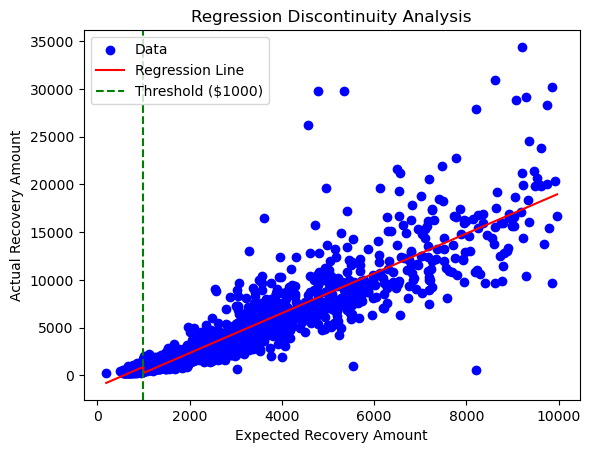

In [35]:
# Create a scatter plot of actual recovery amounts against expected recovery amounts
plt.scatter(bank_data['expected_recovery_amount'], bank_data['actual_recovery_amount'], color='blue', label='Data')
plt.plot(bank_data['expected_recovery_amount'], model.predict(X), color='red', label='Regression Line')
plt.axvline(x=1000, color='green', linestyle='--', label='Threshold ($1000)')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.title('Regression Discontinuity Analysis')
plt.legend()
plt.show()